# **IMPORT LIBRARY**

In [1]:
!pip install emoji
!pip install demoji
!pip install -q sentencepiece protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.8 MB/s eta 0:00:00


In [2]:
!pip install -q transformers datasets evaluate scikit-learn accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import re
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import random
import demoji

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
def set_seed(seed_val=42):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Pastikan algoritma deterministik (hasil pasti sama)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Panggil fungsinya (Angka 42 adalah standar internasional, boleh ganti angka lain)
set_seed(42)

# **LOAD DATA**

In [7]:
df = pd.read_csv("/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/Timnas Indonesia/Dataset - Sheet1.csv")
df.head(15)

,text_display,video_source
0,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+\n \n \n \n Klik disini 👉🏼 https://link.visionplus.id/seagames,Youtube
1,Berasa liat pertandingan antar kecamatan 😂,Youtube
2,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN,Youtube
3,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames 🤣,Youtube
4,Misi sapri dan towel sukses 😂,Youtube
5,Era kegelapan towel telah kembali 😂,Youtube
6,"nonton highlight, terasa aneh\n sepak bola ❌\n rebutan bola lempar ✅",Youtube
7,Dulu lihat timnas begitu menarik utk di tonton sekarang lebih menarik lihat persib apalagi lolos ACL 2,Youtube
8,"Anjir, banner iklannya kurang gede itu.. kalo bisa ditutupi sekalian aja seluruh layar biar makin ga bisa ditonton highlight-nya.",Youtube
9,Timnas seperti ini yang diinginkan Towel dkk 😂,Youtube


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_display  8104 non-null   object
 1   video_source  8117 non-null   object
dtypes: object(2)
memory usage: 127.0+ KB


# **PRE PROCESSING**

## **PREPROCESSING UNTUK KOLOM SENTIMENT**

### **Penanganan Emoji & Emoticon**

In [9]:
custom_emoji_map = {
    "🤡": " badut ",
    "🌾": " ilmu padi ",
    "🔥": " menyala ",
    "🥶": " kedinginan ",
    "🎪": " sirkus ",
    "🗑️": " sampah ",
    "🐐": " goat ",
    "👑": " king ",
    "🚑": " ambulan ",
    "🤮": " jijik ",
    "🥱": " ngantuk ",
    "💔": " kecewa ",
    "🤬": " kasar ",
    "🥀": " layu ",
    "💸": " mafia ",
    "💰": " uang ",
    "🤣": " ngakak ",
    "😂": " lawak ",
    "🤭": " ups ",
    "😆": " wkwk ",
    "😝": " wle ",
    "🤪": " gila ",
    "😅": " hedeh ",
    "🤫": " stt "
}

df['text_emoji_sentiment'] = df['text_display'].fillna('').astype(str)

pattern = re.compile('|'.join(re.escape(key) for key in custom_emoji_map.keys()))

def replace_custom(match):
    return custom_emoji_map[match.group(0)]

df['text_emoji_sentiment'] = df['text_emoji_sentiment'].apply(lambda x: pattern.sub(replace_custom, x))

df['text_emoji_sentiment'] = df['text_emoji_sentiment'].apply(lambda x: emoji.demojize(x, language='id'))

def clean_demojize(text):
    text = re.sub(r':([a-z_]+):', lambda m: ' ' + m.group(1).replace('_', ' ') + ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text_emoji_sentiment'] = df['text_emoji_sentiment'].apply(clean_demojize)

df[['text_display', 'text_emoji_sentiment']].head(15)

,text_display,text_emoji_sentiment
0,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+\n \n \n \n Klik disini 👉🏼 https://link.visionplus.id/seagames,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+ Klik disini :menunjuk_ke_arah_kanan_warna_kulit_cerah-sedang: https://link.visionplus.id/seagames
1,Berasa liat pertandingan antar kecamatan 😂,Berasa liat pertandingan antar kecamatan lawak
2,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN
3,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames 🤣,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames ngakak
4,Misi sapri dan towel sukses 😂,Misi sapri dan towel sukses lawak
5,Era kegelapan towel telah kembali 😂,Era kegelapan towel telah kembali lawak
6,"nonton highlight, terasa aneh\n sepak bola ❌\n rebutan bola lempar ✅","nonton highlight, terasa aneh sepak bola tanda silang rebutan bola lempar tanda centang putih tebal"
7,Dulu lihat timnas begitu menarik utk di tonton sekarang lebih menarik lihat persib apalagi lolos ACL 2,Dulu lihat timnas begitu menarik utk di tonton sekarang lebih menarik lihat persib apalagi lolos ACL 2
8,"Anjir, banner iklannya kurang gede itu.. kalo bisa ditutupi sekalian aja seluruh layar biar makin ga bisa ditonton highlight-nya.","Anjir, banner iklannya kurang gede itu.. kalo bisa ditutupi sekalian aja seluruh layar biar makin ga bisa ditonton highlight-nya."
9,Timnas seperti ini yang diinginkan Towel dkk 😂,Timnas seperti ini yang diinginkan Towel dkk lawak


### **Text Normalization**

In [10]:
df_norm = pd.read_csv("/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/Timnas Indonesia/kamus_alay.csv")
slang_dict = dict(zip(df_norm['slang'], df_norm['formal']))

def hapus_katapanjang(text):
  return re.sub(r'(.)\1{2,}', r'\1', text)

def hapus_spesial_karakter(text):
  return re.sub(r'[^-Za-z0-9\s?!]', '', text)

def text_normalization(text):
  text = str(text).lower()
  text = hapus_katapanjang(text)
  text = hapus_spesial_karakter(text)

  words = text.split()
  normalized_words = [slang_dict.get(word, word) for word in words]
  text = " ".join(normalized_words)

  text = re.sub(r'\s+', ' ', text).strip()

  return text

df['text_clean_sentiment'] = df['text_emoji_sentiment'].apply(text_normalization)
df[['text_display', 'text_emoji_sentiment', 'text_clean_sentiment']].head(15)

,text_display,text_emoji_sentiment,text_clean_sentiment
0,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+\n \n \n \n Klik disini 👉🏼 https://link.visionplus.id/seagames,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+ Klik disini :menunjuk_ke_arah_kanan_warna_kulit_cerah-sedang: https://link.visionplus.id/seagames,tonton highlightsfull match lebih cepat dan lengkap dengan fitur catch-up hanya di vision klik disini menunjukkearahkananwarnakulitcerah-sedang httpslinkvisionplusidseagames
1,Berasa liat pertandingan antar kecamatan 😂,Berasa liat pertandingan antar kecamatan lawak,berasa lihat pertandingan antar kecamatan lawak
2,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN,luar biasa selamat atas pertama kali tidak lolos semifinal seagames dalam 15 tahun
3,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames 🤣,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames ngakak,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames mengakak
4,Misi sapri dan towel sukses 😂,Misi sapri dan towel sukses lawak,misi sapri dan towel sukses lawak
5,Era kegelapan towel telah kembali 😂,Era kegelapan towel telah kembali lawak,era kegelapan towel telah kembali lawak
6,"nonton highlight, terasa aneh\n sepak bola ❌\n rebutan bola lempar ✅","nonton highlight, terasa aneh sepak bola tanda silang rebutan bola lempar tanda centang putih tebal",menonton highlight terasa aneh sepak bola tanda silang rebutan bola lempar tanda centang putih tebal
7,Dulu lihat timnas begitu menarik utk di tonton sekarang lebih menarik lihat persib apalagi lolos ACL 2,Dulu lihat timnas begitu menarik utk di tonton sekarang lebih menarik lihat persib apalagi lolos ACL 2,dulu lihat timnas begitu menarik untuk di tonton sekarang lebih menarik lihat persib apalagi lolos acl 2
8,"Anjir, banner iklannya kurang gede itu.. kalo bisa ditutupi sekalian aja seluruh layar biar makin ga bisa ditonton highlight-nya.","Anjir, banner iklannya kurang gede itu.. kalo bisa ditutupi sekalian aja seluruh layar biar makin ga bisa ditonton highlight-nya.",anjir banner iklannya kurang gede itu kalo bisa ditutupi sekalian saja seluruh layar biar makin enggak bisa ditonton highlight-nya
9,Timnas seperti ini yang diinginkan Towel dkk 😂,Timnas seperti ini yang diinginkan Towel dkk lawak,timnas seperti ini yang diinginkan towel dkk lawak


## **PREPROCESSING UNTUK KOLOM SARCASM**

### **Penanganan Emoji & Emoticon**

In [11]:
def handle_emoji_sarcasm(text):
    # Mengubah emoji menjadi deskripsi teks (misal: 🤡 menjadi :clown_face:)
    return demoji.replace_with_desc(text, sep=" ")

### **Hapus Spesial Karakter**

In [12]:
def hapus_spesial_karakter_sarcasm(text):
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Menghapus Mention (@) dan Hashtag (#)
    text = re.sub(r'@\w+|#\w+', '', text)
    # Menghapus karakter spesial KECUALI tanda seru, tanya, dan petik
    # Regex ini menghapus semua kecuali huruf, angka, dan ! ? "
    text = re.sub(r'[^a-zA-Z0-9\s\!\?\"]', '', text)
    # Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### **Integrasi Fungsi**

In [13]:
def text_clean_sarcasm(text):
    text = str(text).lower() # Tetap lowercase untuk IndoBERT-base-uncased
    text = handle_emoji_sarcasm(text) # Terjemahkan emoji dulu
    text = text_normalization(text) # Gunakan kamus slang Anda (tetap penting!)
    text = hapus_spesial_karakter_sarcasm(text) # Versi ringan yang simpan !?"
    return text

df['text_clean_sarcasm'] = df['text_display'].apply(text_clean_sarcasm)

print("Perbandingan Teks Asli vs Teks Khusus Sarkasme:")
display(df[['text_display', 'text_clean_sarcasm']].head())

Perbandingan Teks Asli vs Teks Khusus Sarkasme:


,text_display,text_clean_sarcasm
0,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+\n \n \n \n Klik disini 👉🏼 https://link.visionplus.id/seagames,tonton highlightsfull match lebih cepat dan lengkap dengan fitur catchup hanya di vision klik disini backhand index pointing right mediumlight skin tone
1,Berasa liat pertandingan antar kecamatan 😂,berasa lihat pertandingan antar kecamatan face with tears of joy
2,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN,luar biasa selamat atas pertama kali tidak lolos semifinal seagames dalam 15 tahun
3,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames 🤣,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames rolling on the floor laughing
4,Misi sapri dan towel sukses 😂,misi sapri dan towel sukses face with tears of joy


## **HAPUS KALIMAT YANG PENDEK DAN PANJANG**

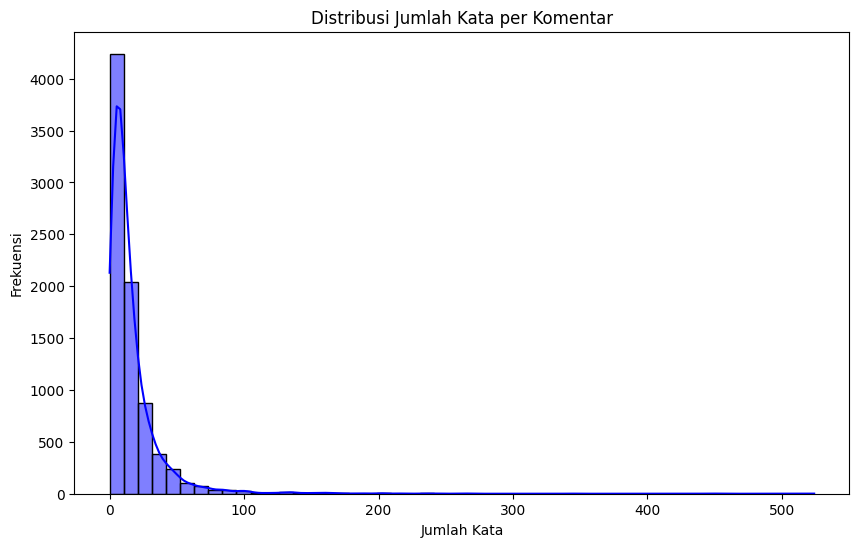

count    8117.000000
mean       16.299864
std        24.295926
min         0.000000
25%         5.000000
50%        10.000000
75%        19.000000
max       524.000000
Name: word_count_sentiment, dtype: float64


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah kata per kalimat
df['word_count_sentiment'] = df['text_clean_sentiment'].str.split().str.len()

# Visualisasi Distribusi Panjang Kata
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count_sentiment'], bins=50, kde=True, color='blue')
plt.title('Distribusi Jumlah Kata per Komentar')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

# Lihat statistik deskriptif
print(df['word_count_sentiment'].describe())

In [15]:
df.head()

,text_display,video_source,text_emoji_sentiment,text_clean_sentiment,text_clean_sarcasm,word_count_sentiment
0,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+\n \n \n \n Klik disini 👉🏼 https://link.visionplus.id/seagames,Youtube,Tonton highlights/full match lebih cepat dan lengkap dengan fitur Catch-Up hanya di VISION+ Klik disini :menunjuk_ke_arah_kanan_warna_kulit_cerah-sedang: https://link.visionplus.id/seagames,tonton highlightsfull match lebih cepat dan lengkap dengan fitur catch-up hanya di vision klik disini menunjukkearahkananwarnakulitcerah-sedang httpslinkvisionplusidseagames,tonton highlightsfull match lebih cepat dan lengkap dengan fitur catchup hanya di vision klik disini backhand index pointing right mediumlight skin tone,17
1,Berasa liat pertandingan antar kecamatan 😂,Youtube,Berasa liat pertandingan antar kecamatan lawak,berasa lihat pertandingan antar kecamatan lawak,berasa lihat pertandingan antar kecamatan face with tears of joy,6
2,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN,Youtube,Luar biasa. Selamat atas PERTAMA KALI TIDAK LOLOS SEMIFINAL SEAGAMES DLM 15 TAHUN,luar biasa selamat atas pertama kali tidak lolos semifinal seagames dalam 15 tahun,luar biasa selamat atas pertama kali tidak lolos semifinal seagames dalam 15 tahun,13
3,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames 🤣,Youtube,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames ngakak,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames mengakak,dari semifinalis piala asia u23 sampai jadi ampas di selevel2 seagames rolling on the floor laughing,12
4,Misi sapri dan towel sukses 😂,Youtube,Misi sapri dan towel sukses lawak,misi sapri dan towel sukses lawak,misi sapri dan towel sukses face with tears of joy,6


In [16]:
df_final = df[(df["word_count_sentiment"] >= 3) & (df["word_count_sentiment"] < 80)]

print(f"data sebelum di hapus : {df.shape}")
print(f"data setelah di hapus : {df_final.shape}")

data sebelum di hapus : (8117, 6)
data setelah di hapus : (7045, 6)


# **LABELLING**

## **ABSC**

In [17]:
aspect_keywords = {
    'Coach_STY': [
        'sty', 'shin tae yong', 'shin', 'si korea', 'oppa', 'shin taeyong',
        'head coach', 'tim kepelatihan', 'pelatih korea', 'jaewoon', 'yong',
        'orang korea', 'coch sty', 'sintayong', 'coach shin', 'yeom',
        'yeom ki hun', 'choi', 'stiy', 'pelatih kepala'
    ],

    'Coach_Kluivert': [
        'patrick', 'kluivert', 'patrick kluivert', 'legenda belanda', 'pk',
        'rumor belanda', 'pelatih barcelona', 'penjudi', 'pelatih baru',
        'petrik', 'eks barcelona', 'calon pelatih', 'pengganti sty',
        'pelatih anyar', 'meneer', 'belanda koneksi'
    ],

    'Coach_Indra': [
        'indra sjafri', 'indra', 'sjafri', 'coach is', 'kumis', 'pelatih lokal',
        'pelatih u-20', 'pelatih teknik', 'pelatih seagames', 'pelatih u20',
        'sapri', 'indra safri', 'pepepa', 'lokal pride pelatih', 'dirtek',
        'coach indra', 'guru penjas', 'penjas'
    ],

    'Mgmt_ET': [
        'erick', 'thohir', 'et', 'pak erick', 'ketum', 'menteri bumn',
        'erick thohir', 'pak ketum', 'arsenal', 'menteri', 'pak et',
        'ketua umum', 'ketum pssi', 'erik tohir', 'erik', 'etho',
        'pak menteri', 'bapak erick', 'king erick'
    ],

    'Mgmt_Arya': [
        'arya', 'sinulingga', 'arya sinulingga', 'pak arya', 'exco arya',
        'botak', 'exco', 'as', 'inisial as', 'pak exco', 'exco pssi',
        'aria', 'sinulinga', 'lingga', 'si botak', 'anggota exco',
        'humas pssi'
    ],

    'Mgmt_General': [
        'pssi', 'federasi', 'asosiasi', 'pengurus', 'seagames', 'manajemen',
        'kantor pssi', 'pusat', 'sepakbola indonesia', 'organisasi'
    ],

    'Match_Issues': [
        'wasit', 'referee', 'ahmed', 'alkaf', 'rumput', 'stadion', 'gbk',
        'tiket', 'var', 'afc', 'fifa', 'bahrain', 'china', 'jepang',
        'saudi', 'curang', 'mafia wasit', 'peluit', 'injury time',
        'pertandingan', 'laga', 'skor', 'rumput jelek', 'sawah', '90+6=99'
    ],

    'Player': [
        'timnas', 'garuda', 'pemain', 'skuad', 'player', 'kapten', 'bola',
        'jay', 'idzes', 'bang jay', 'jayadi',
        'hubner', 'justin', 'preman', 'juh',
        'thom', 'haye', 'profesor', 'toha', 'prof',
        'ridho', 'rizky ridho', 'kapten ridho',
        'ernando', 'nando', 'ari',
        'witan', 'sulaeman', 'hiu kencana',
        'arhan', 'pratama', 'lemparan',
        'marselino', 'lino', 'ferdinan', 'marcelino',
        'ragnar', 'oratmangoen', 'wak haji', 'wak haji ragnar',
        'lokal', 'diaspora', 'naturalisasi', 'grade a', 'grade b', 'keturunan',
        'paes', 'maarten', 'bang paes', 'kiper', 'tembok',
        'verdonk', 'calvin', 'koko',
        'eliano', 'reijnders',
        'mees', 'hilgers', 'el nyengir',
        'kevin', 'diks',
        'asnawi', 'mangkualam', 'nawi',
        'struick', 'rafael', 'el klemer',
        'sananta', 'ramadhan',
        'egy', 'maulana', 'vikri',
        'jordi', 'amat', 'prince'
    ],

    'Pundit': [
        'towel', 'bung towel', 'pengamat', 'komentator', 'pundit',
        'tommy welly', 'suporter layar kaca', 'bung', 'akmal',
        'marhali', 'akmal marhali', 'bung binder', 'binder',
        'coach justin', 'koci', 'justinus', 'laksana', 'media',
        'wartawan', 'host', 'podcaster'
    ]
}

ASPECT_PRIORITY = {
    'Coach_STY': 1,
    'Coach_Indra': 7,
    'Coach_Kluivert': 5,
    'Mgmt_ET': 2,
    'Mgmt_Arya': 3,
    'Player': 6,
    'Pundit': 4,
    'Match_Issues': 8,
    'Mgmt_General': 9
}

In [18]:

def get_dominant_aspect_smart(text, aspect_dict):
    text = str(text).lower()
    scores = {}

    for category, keywords in aspect_dict.items():
        count = 0
        for key in keywords:
            matches = len(re.findall(r"\b" + re.escape(key) + r"\b", text))
            count += matches

        if count > 0:
            scores[category] = count

    if not scores:
        return 'General' # Atau Match_Issues default

    sorted_aspects = sorted(
        scores.items(),
        key=lambda item: (-item[1], ASPECT_PRIORITY.get(item[0], 99))
    )

    # Ambil pemenang (elemen pertama)
    winner_aspect = sorted_aspects[0][0]

    return winner_aspect

# Cara pakai di Pandas
df_final['aspect_category'] = df_final['text_clean_sentiment'].apply(
    lambda x: get_dominant_aspect_smart(x, aspect_keywords)
)

/tmp/ipython-input-3691952777.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['aspect_category'] = df_final['text_clean_sentiment'].apply(


In [19]:
df_final['aspect_category'].value_counts()

,count
aspect_category,
General,2465
Coach_STY,1584
Player,1325
Mgmt_ET,572
Mgmt_General,272
Pundit,259
Coach_Indra,186
Coach_Kluivert,137
Match_Issues,130


In [20]:
df_final.to_csv('/content/df_final.csv', index=False)

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7045 entries, 0 to 8115
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   text_display          7045 non-null   object
 1   video_source          7045 non-null   object
 2   text_emoji_sentiment  7045 non-null   object
 3   text_clean_sentiment  7045 non-null   object
 4   text_clean_sarcasm    7045 non-null   object
 5   word_count_sentiment  7045 non-null   int64 
 6   aspect_category       7045 non-null   object
dtypes: int64(1), object(6)
memory usage: 440.3+ KB


## **GEMINI**

In [22]:
# import pandas as pd
# import google.generativeai as genai
# import time
# import json
# import threading
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm
# import os
# import re

# # --- CONFIGURATION ---
# API_KEY = "MASUKKAN_KEY_PRO_TEMANMU_DISINI"
# MODEL_NAME = 'gemini-2.5-flash-lite'

# # Tuning (API Pro)
# BATCH_SIZE = 10
# MAX_WORKERS = 20

# INPUT_FILE = "df_final.csv"
# OUTPUT_FILE = "dataset_labeled_final.csv"

# # --- SYSTEM PROMPT ---
# SYSTEM_PROMPT = """
# Role: Analis Sentimen Sepak Bola Indonesia.
# Task: Labeli data berikut.

# 1. is_sarcastic (1=Ya, 0=Tidak).
#    Context: Kata "Ilmu Padi", "King", "Menyala", "Local Pride" pada konteks negatif/ejekan adalah Sarkas (1).

# 2. sentiment (Positive, Negative, Neutral).

# Output: JSON Array murni. Contoh: [{"id": 0, "sarcasm": 1, "sentiment": "Negative"}]
# No markdown. No explanation.
# """

# # --- MAIN LOGIC ---

# genai.configure(api_key=API_KEY)
# csv_lock = threading.Lock()

# def clean_json_string(text):
#     # Hapus markdown formatting jika ada
#     text = re.sub(r'```json|```', '', text)

#     # Ambil hanya bagian array [...]
#     start = text.find('[')
#     end = text.rfind(']') + 1
#     if start != -1 and end != 0:
#         return text[start:end]
#     return text

# def process_batch(batch_df):
#     # Prepare data payload
#     data_list = []
#     for idx, row in batch_df.iterrows():
#         # Sanitize text input
#         clean_text = str(row['text_clean']).replace('"', "'").replace('\n', ' ')
#         data_list.append({
#             "id": idx,
#             "text": clean_text,
#             "aspect": str(row['aspect_category'])
#         })

#     user_message = f"Data:\n{json.dumps(data_list)}"

#     try:
#         model = genai.GenerativeModel(
#             model_name=MODEL_NAME,
#             generation_config={
#                 "temperature": 0.1,
#                 "top_p": 0.95,
#                 "top_k": 40
#             }
#         )

#         response = model.generate_content([SYSTEM_PROMPT, user_message])

#         # Manual Parsing (karena model Lite kadang raw text)
#         cleaned_response = clean_json_string(response.text)
#         results = json.loads(cleaned_response)

#         if isinstance(results, list) and len(results) > 0:
#             return results

#     except Exception as e:
#         # Error handling simple
#         if "429" in str(e):
#             time.sleep(2) # Rate limit hit
#         elif "400" in str(e):
#             print(f"[WARN] Bad Request di batch {batch_df.index[0]}: {e}")
#         else:
#             pass # Skip error lain biar log gak penuh

#     return None

# def main():
#     print(f"[INFO] Starting Labeling Job")
#     print(f"[INFO] Model: {MODEL_NAME} | Workers: {MAX_WORKERS}")

#     if not os.path.exists(INPUT_FILE):
#         print(f"[ERROR] Input file {INPUT_FILE} not found.")
#         return

#     # Load Data
#     df = pd.read_csv(INPUT_FILE)
#     df = df.reset_index(drop=True) # Wajib reset index jadi ID

#     # Define columns to keep (cegah tabrakan nama kolom)
#     existing_cols = [c for c in df.columns if c not in ['sentiment', 'is_sarcastic', 'sarcasm']]
#     final_cols = existing_cols + ['is_sarcastic', 'sentiment']

#     # Init Output File
#     if not os.path.exists(OUTPUT_FILE):
#         pd.DataFrame(columns=final_cols).to_csv(OUTPUT_FILE, index=False)

#     # Create Batches
#     batches = [df.iloc[i : i + BATCH_SIZE] for i in range(0, len(df), BATCH_SIZE)]
#     print(f"[INFO] Total Data: {len(df)} | Batches: {len(batches)}")

#     processed_count = 0

#     # Execute Thread Pool
#     with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
#         futures = {executor.submit(process_batch, batch): batch for batch in batches}

#         # Progress bar simple
#         progress_bar = tqdm(as_completed(futures), total=len(batches), unit="batch")

#         for future in progress_bar:
#             batch_result = future.result()
#             original_batch = futures[future]

#             if batch_result:
#                 result_df = pd.DataFrame(batch_result)

#                 # Validation & Merge logic
#                 if 'id' in result_df.columns and 'sentiment' in result_df.columns:
#                     # Rename sarcasm col if needed
#                     if 'sarcasm' in result_df.columns:
#                         result_df = result_df.rename(columns={'sarcasm': 'is_sarcastic'})

#                     # Ensure ID type match
#                     result_df['id'] = result_df['id'].astype(int)

#                     # Prepare original batch for merge
#                     temp_df = original_batch.copy()
#                     temp_df = temp_df[existing_cols] # Drop old labels if any
#                     temp_df['temp_id'] = temp_df.index

#                     # Merge data
#                     merged = temp_df.merge(result_df, left_on='temp_id', right_on='id', how='inner')

#                     if not merged.empty:
#                         # Reorder columns safely
#                         final_chunk = pd.DataFrame()
#                         for col in final_cols:
#                             final_chunk[col] = merged.get(col)

#                         # Write to CSV (Thread Safe)
#                         with csv_lock:
#                             final_chunk.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)

#                         processed_count += len(final_chunk)

#             progress_bar.set_description(f"Done: {processed_count}")

#     print(f"\n[DONE] Finished. {processed_count}/{len(df)} rows labeled.")

# if __name__ == "__main__":
#     main()

# **EXPLOR DATASET LABEL**

In [23]:
df_label = pd.read_csv("/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/Timnas Indonesia/dataset_labeled_final.csv")
df_label.head(20)

,text_display,video_source,text_emoji,text_clean,word_count,aspect_category,is_sarcastic,sentiment
0,Raven di cadangkan di awal ekskskksskskkekskskekssk,Youtube,Raven di cadangkan di awal ekskskksskskkekskskekssk,raven di cadangkan di awal ekskskksskskkekskskekssk,6,General,0,Negative
1,towel tersenyum bahagia,Youtube,towel tersenyum bahagia,towel tersenyum bahagia,3,Pundit,0,Positive
2,Diam adalah luapan kekecewaan dan ketidakpedulian yg tidak terbatas😮,Youtube,Diam adalah luapan kekecewaan dan ketidakpedulian yg tidak terbatas wajah dengan mulut terbuka,diam adalah luapan kekecewaan dan ketidakpedulian yang tidak terbatas wajah dengan mulut terbuka,13,General,0,Negative
3,Pengen jadi bintang semua. Gak mau membagi bola😂,Youtube,Pengen jadi bintang semua. Gak mau membagi bola lawak,pengin jadi bintang semua enggak mau membagi bola lawak,9,Player,0,Negative
4,Sumpah...kl didepan gawang tim indonesia persis main tarkam,Youtube,Sumpah...kl didepan gawang tim indonesia persis main tarkam,sumpahkl didepan gawang tim indonesia persis main tarkam,8,General,0,Negative
5,Woolah sedih sedih gimana gitu..\r\n .itulah PSSI,Youtube,Woolah sedih sedih gimana gitu.. .itulah PSSI,woolah sedih sedih bagaimana begitu itulah pssi,7,Mgmt_General,0,Negative
6,Erik tohir suruh golin,Youtube,Erik tohir suruh golin,erik tohir suruh golin,4,Mgmt_ET,0,Neutral
7,"Towel: tor monitor ketua, mission complate ketua. 🤣🤣",Youtube,"Towel: tor monitor ketua, mission complate ketua. ngakak ngakak",towel tor monitor ketua mission complate ketua mengakak mengakak,9,Pundit,0,Positive
8,Mumet2 federasi dengerin towel 😂,Youtube,Mumet2 federasi dengerin towel lawak,mumet2 federasi mendengarkan towel lawak,5,Mgmt_General,1,Negative
9,inilah yang diinginkan exco dan pssi kembali ke setelan pabrik..kalau bisa mundur buat apa maju..🤣🤣🤣,Youtube,inilah yang diinginkan exco dan pssi kembali ke setelan pabrik..kalau bisa mundur buat apa maju.. ngakak ngakak ngakak,inilah yang diinginkan exco dan pssi kembali ke setelan pabrikkalau bisa mundur buat apa maju mengakak mengakak mengakak,18,Mgmt_Arya,1,Negative


In [24]:
df['word_count_sentiment'].describe()

,word_count_sentiment
count,8117.000000
mean,16.299864
std,24.295926
min,0.000000
25%,5.000000
50%,10.000000
75%,19.000000
max,524.000000


In [25]:
df_final = df_final.reset_index(drop=True)
df_final['id'] = df_final.index

if 'id' in df_label.columns:
    df_label['id'] = df_label['id'].astype(int)
else:
    df_label = df_label.reset_index(drop=True)
    df_label['id'] = df_label.index

df_result = df_final.merge(
    df_label[['id', 'is_sarcastic', 'sentiment']],
    on='id',
    how='inner'
)

In [26]:
# List kata kunci yang menandakan "Kangen STY" tapi nadanya sedih
keywords_rindu = [
    'tanpa sty', 'sejak sty', 'era sty', 'jaman sty', 'zaman sty',
    'balik lagi', 'kangen', 'rindu', 'kembali sty', 'harap sty',
    'andaikan sty', 'kalau sty', 'kalo sty', 'sejak sty', 'miss sty', 'balikin sty',
    'sty berhenti'
]

def fix_sty_sentiment(row):
    text = row['text_clean_sentiment'].lower()
    aspect = row['aspect_category']
    current_sentiment = row['sentiment']

    # Hanya cek jika aspeknya STY dan sentimen awalnya Negatif
    if aspect == 'Coach_STY' and current_sentiment == 'Negative':
        # Jika mengandung kata-kata "Rindu", ubah jadi Positive
        if any(word in text for word in keywords_rindu):
            return 'Positive'

    return current_sentiment

# Terapkan perbaikan
df_result['sentiment'] = df_result.apply(fix_sty_sentiment, axis=1)

print("Label Sentimen STY berhasil diperbaiki! Coba cek grafik lagi.")

Label Sentimen STY berhasil diperbaiki! Coba cek grafik lagi.


# **TRAINING MODEL SENTIMENT**

In [27]:
# Mapping Label Sentimen (Text -> Angka)
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df_result['label'] = df_result['sentiment'].map(label_map)

# Cek kalau ada label ngaco (selain Pos/Neg/Neu)
df_result = df_result.dropna(subset=['label']) # Buang yang gagal mapping
df_result['label'] = df_result['label'].astype(int)


In [28]:
# 1. Cek jumlah awal
print(f"Total data awal: {len(df)}")

# 2. FILTER: Hapus baris yang labelnya Netral (Anggaplah Netral = 1)
# Kita hanya ambil data yang labelnya 0 (Negatif) atau 2 (Positif)
df_binary = df_result[df_result['label'] != 1].copy()

# 3. MAPPING ULANG LABEL (Wajib jadi 0 dan 1)
# Karena Binary Classification butuh label 0 dan 1.
# Saat ini labelmu: 0 (Negatif) dan 2 (Positif). Kita harus ubah 2 jadi 1.
def remap_label(x):
    if x == 0: return 0  # Negatif tetap 0
    if x == 2: return 1  # Positif jadi 1
    return x

df_binary['label'] = df_binary['label'].apply(remap_label)

print(f"Total data binary (Pos vs Neg): {len(df_binary)}")

Total data awal: 8117
Total data binary (Pos vs Neg): 5732


In [29]:
# from sklearn.utils import resample
# import pandas as pd

# # 1. Cek dulu distribusi awal (biar tahu timpangnya seberapa parah)
# print("Distribusi Awal:")
# print(df_result['label'].value_counts())

# # 2. Pisahkan DataFrame berdasarkan Label
# df_neg = df_binary[df_binary['label'] == 0]
# df_pos = df_binary[df_binary['label'] == 1]

# # 3. Tentukan Target Jumlah (Strategi: Ikuti jumlah kelas terkecil)
# # Kita cari siapa yang paling sedikit datanya
# minority_count = min(len(df_neg), len(df_pos))

# # Opsional: Kalau mau data mayoritas lebih banyak sedikit (misal 1.5x lipat), ubah baris ini:
# # target_count = int(minority_count * 1.5)
# target_count = minority_count  # Saya set 1:1 (Setara) agar F1-Score maksimal

# print(f"\nTarget jumlah data per kelas: {target_count}")

# # 4. Lakukan Downsampling
# # Fungsi ini akan membuang sebagian data mayoritas secara acak
# def downsample_segment(df_segment, target_n):
#     if len(df_segment) > target_n:
#         return resample(df_segment,
#                         replace=False,    # False = Jangan ambil data double
#                         n_samples=target_n,
#                         random_state=42)  # Biar hasil acaknya konsisten
#     return df_segment

# df_neg_balanced = downsample_segment(df_neg, target_count)
# df_pos_balanced = downsample_segment(df_pos, target_count)

# # 5. Gabungkan Kembali Jadi Satu DataFrame Baru
# df_balanced = pd.concat([df_neg_balanced, df_pos_balanced])

# # Acak urutannya (Shuffle) biar tidak berkelompok
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# print("\nDistribusi Baru (Balanced):")
# print(df_balanced['label'].value_counts())

## **Pembagian Dataset**

In [30]:
train_df, temp_df = train_test_split(df_binary, test_size=0.2, random_state=42, stratify=df_binary['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Konversi ke Format HuggingFace
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

Train: 4585 | Val: 573 | Test: 574


## ***indobert-base-p1***

### **Tokenization**

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Ganti nama checkpoint
model_checkpoint = "indobenchmark/indobert-base-p1"

# 2. Load Tokenizer BARU
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text_clean_sentiment"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4585 [00:00<?, ? examples/s]

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

Map:   0%|          | 0/574 [00:00<?, ? examples/s]

### **Setup Training (Trainer API)**

In [32]:
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

f1_metric = evaluate.load("f1")
acc_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    acc = acc_metric.compute(predictions=predictions, references=labels)

    return {"accuracy": acc["accuracy"], "f1_macro": f1["f1"]}

# Load Model Kosong (Pre-trained)
id2label={0: "Negative", 1: "Positive"} # Koma di akhir telah dihapus
label2id={"Negative": 0, "Positive": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Eksekusi Training (Fine-Tuning)**

In [33]:
!pip install --upgrade transformers

training_args = TrainingArguments(
    output_dir="./indobert-base-optimized",

    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,

    learning_rate=3e-5,

    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,

    # EVALUASI
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=True # Biar ngebut
)

# --- 3. TRAINER DENGAN EARLY STOPPING ---
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# GASKEUN! 🚀
trainer.train()

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

/tmp/ipython-input-41702099.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.525483,0.746946,0.683664
2,No log,0.528882,0.753927,0.733325
3,No log,0.543632,0.752182,0.740060


TrainOutput(global_step=432, training_loss=0.5115779594138816, metrics={'train_runtime': 106.2394, 'train_samples_per_second': 129.472, 'train_steps_per_second': 4.066, 'total_flos': 452386570809600.0, 'train_loss': 0.5115779594138816, 'epoch': 3.0})

## ***xlm-roberta-large***

In [34]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# # 1. Ganti Checkpoint
# model_checkpoint = "xlm-roberta-large"

# # 2. Load Tokenizer & Model
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# # PENTING: XLM-R Large butuh definisi label yang jelas di awal
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_checkpoint,
#     num_labels=2, # Binary
#     id2label={0: "Negative", 1: "Positive"},
#     label2id={"Negative": 0, "Positive": 1},
#     # Dropout tinggi biar gak cepat overfitting (karena datanya dikit buat model segede ini)
#     hidden_dropout_prob=0.2,
#     attention_probs_dropout_prob=0.2
# )

# # 3. Tokenisasi Ulang (WAJIB - Kamusnya Beda!)
# # XLM-R pakai SentencePiece, jadi hasil tokenisasinya beda total.
# def tokenize_function(examples):
#     return tokenizer(examples["text_clean_sentiment"], padding="max_length", truncation=True, max_length=64)

# tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [35]:
# training_args = TrainingArguments(
#     output_dir="./xlm-r-large-binary",

#     # --- MEMORY SAVING MODE ON ---
#     per_device_train_batch_size=4,   # Kecilkan ekstrem (4 atau 2)
#     per_device_eval_batch_size=4,
#     gradient_accumulation_steps=8,   # 4 x 8 = 32 (Setara batch 32)
#     gradient_checkpointing=True,     # Wajib nyala buat model Large di GPU gratisan
#     fp16=True,                       # Wajib nyala

#     # --- HYPERPARAMETER ---
#     learning_rate=1e-5,              # LR harus KECIL (Large model sensitif)
#     num_train_epochs=5,              # Coba 5 dulu
#     weight_decay=0.01,

#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     metric_for_best_model="f1_macro",
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Kesabaran tipis aja
# )

# trainer.train()

## ***IndoBERT Large (IndoNLU)***

In [36]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
# import torch

# # --- CONFIGURATION ---
# model_checkpoint = "indobenchmark/indobert-large-p2"
# MAX_LEN = 64 # Tetap pendek agar hemat memori

# # 1. LOAD TOKENIZER
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# # 2. TOKENISASI ULANG (Wajib karena beda model)
# def tokenize_function(examples):
#     return tokenizer(examples["text_clean_sentiment"], padding="max_length", truncation=True, max_length=MAX_LEN)

# tokenized_datasets = dataset.map(tokenize_function, batched=True)

# # 3. LOAD MODEL DENGAN REGULARISASI EKSTRA
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_checkpoint,
#     num_labels=2,
#     id2label={0: "Negative", 1: "Positive"},
#     label2id={"Negative": 0, "Positive": 1},

#     # --- PENTING: PENGAMAN OVERFITTING ---
#     hidden_dropout_prob=0.3,          # Persulit model menghafal (Default 0.1)
#     attention_probs_dropout_prob=0.3  # Persulit attention mechanism
# )

# # 4. TRAINING ARGUMENTS (ANTI-OOM)
# training_args = TrainingArguments(
#     output_dir="./indonlu-large-binary",

#     # Mode Hemat Memori (Gradient Accumulation)
#     per_device_train_batch_size=4,    # Batch kecil
#     per_device_eval_batch_size=4,
#     gradient_accumulation_steps=8,    # 4 x 8 = 32 (Virtual Batch Size)
#     gradient_checkpointing=True,      # Fitur wajib buat Large Model
#     fp16=True,                        # Mixed Precision

#     learning_rate=1e-5,               # LR Kecil karena model Large sensitif
#     num_train_epochs=3,               # Sedikit lebih lama
#     weight_decay=0.02,                # Hukuman diperbesar

#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     metric_for_best_model="f1_macro",
# )

# # 5. TRAINER
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
# )

# print("Mulai Training IndoNLU Large...")
# trainer.train()

### ***IndoBERT Base (IndoLEM)***

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

# --- CONFIGURATION ---
# IndoLEM biasanya performanya bagus di checkpoint ini
model_checkpoint = "indolem/indobert-base-uncased"
MAX_LEN = 64

# 1. LOAD TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 2. TOKENISASI ULANG
def tokenize_function(examples):
    # IndoLEM Uncased butuh input lowercase (text_clean kamu sudah lower, jadi aman)
    return tokenizer(examples["text_clean_sentiment"], padding="max_length", truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 3. LOAD MODEL
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label={0: "Negative", 1: "Positive"},
    label2id={"Negative": 0, "Positive": 1},
    # Dropout standar saja karena ini model Base
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

# 4. TRAINING ARGUMENTS (STANDARD BASE)
training_args = TrainingArguments(
    output_dir="./indolem-base-binary",

    # Settingan Base yang Stabil
    per_device_train_batch_size=32,   # Base kuat nampung 32
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,    # Tidak perlu akumulasi
    fp16=True,

    learning_rate=3e-5,               # LR Standar
    num_train_epochs=4,               # Epoch standar
    weight_decay=0.01,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
)

# 5. TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Mulai Training IndoLEM Base...")
trainer.train()

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4585 [00:00<?, ? examples/s]

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

Map:   0%|          | 0/574 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3150212255.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Mulai Training IndoLEM Base...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.528289,0.734729,0.692599
2,No log,0.545951,0.757417,0.698652
3,No log,0.517521,0.746946,0.722575
4,0.521200,0.555049,0.746946,0.721466


TrainOutput(global_step=576, training_loss=0.5105326705508761, metrics={'train_runtime': 138.4439, 'train_samples_per_second': 132.472, 'train_steps_per_second': 4.161, 'total_flos': 603182094412800.0, 'train_loss': 0.5105326705508761, 'epoch': 4.0})

<Figure size 800x600 with 0 Axes>

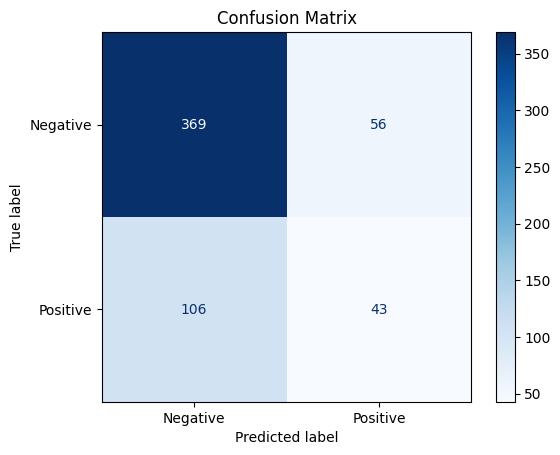

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Lakukan prediksi pada dataset test
predictions = trainer.predict(tokenized_datasets["test"])

# Ambil label prediksi dari logits
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Buat Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) # Sesuaikan dengan label Anda (Negative, Neutral, Positive)
display_labels = [id2label[i] for i in sorted(id2label.keys())] # Ambil nama label

# Visualisasikan Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# 1. AMBIL PREDIKSI DARI MODEL
# Model disuruh menebak data test set
print("Sedang menghitung prediksi...")
raw_pred, y_true, _ = trainer.predict(tokenized_datasets["test"])
y_pred = np.argmax(raw_pred, axis=1)

# 2. HITUNG METRIK (Bagian Atas Gambar)
# Kita gunakan 'macro' karena kamu punya 3 kelas (imbalance handled by macro)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# 3. PRINT HASIL (Diformat mirip gambar kamu)
print("\n" + "="*30)
print(f"Model Accuracy : {acc:.2f}")     # Dibulatkan 2 desimal biar rapi
print(f"Model Precision: {prec}")
print(f"Model Recall   : {rec}")
print(f"Model F1 Score : {f1}")
print("\nconfusion_matrix:")
print(confusion_matrix(y_true, y_pred))

print("-" * 60) # Garis putus-putus pemisah

# 4. TABEL CLASSIFICATION REPORT (Bagian Bawah Gambar)
# Pastikan urutan target_names sesuai dengan label map kamu (0, 1, 2)
target_names = ["Negative", "Positive"]

print(classification_report(y_true, y_pred, target_names=target_names))
print("="*30)

Sedang menghitung prediksi...



Model Accuracy : 0.72
Model Precision: 0.6055927698032961
Model Recall   : 0.5784129490722464
Model F1 Score : 0.5833870967741935

confusion_matrix:
[[369  56]
 [106  43]]
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.78      0.87      0.82       425
    Positive       0.43      0.29      0.35       149

    accuracy                           0.72       574
   macro avg       0.61      0.58      0.58       574
weighted avg       0.69      0.72      0.70       574



## **EVALUASI & SAVE MODEL SENTIMENT**

In [40]:
# Evaluasi di data Test
print("Evaluasi Data Test...")
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Simpan Model Final (Biar bisa dipake offline nanti)
trainer.save_model("./model_final_indobertweet")
print("Model tersimpan di folder 'model_final_indobertweet'!")

Evaluasi Data Test...


{'eval_loss': 0.5745155215263367, 'eval_accuracy': 0.7177700348432056, 'eval_f1_macro': 0.6971591547712712, 'eval_runtime': 0.5893, 'eval_samples_per_second': 973.98, 'eval_steps_per_second': 30.543, 'epoch': 4.0}
Model tersimpan di folder 'model_final_indobertweet'!


# **TRAINING MODEL SARKAS**

### **Pembagian Dataset**

In [42]:
train_val_dfs, test_dfs = train_test_split(df_binary, test_size=0.1, random_state = 42, stratify = df_binary['is_sarcastic'])
train_dfs, val_dfs = train_test_split(train_val_dfs, test_size=0.1, random_state = 42, stratify = train_val_dfs['is_sarcastic'])

print(f"Data Training :  {len(train_dfs)}")
print(f"Data Validation : {len(val_dfs)}")
print(f"Data Testing :    {len(test_dfs)}")

Data Training :  4642
Data Validation : 516
Data Testing :    574


In [43]:
dataset_sarcasm = DatasetDict({
    "train": Dataset.from_pandas(train_dfs.reset_index(drop = True)),
    "validation": Dataset.from_pandas(val_dfs.reset_index(drop = True)),
    "test": Dataset.from_pandas(test_dfs.reset_index(drop = True))
})

## ***IndoBERT-base-p1***

In [45]:
model_checkpoint = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text_clean_sarcasm"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset_sarcasm.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("is_sarcastic", "labels")

f1_metric = evaluate.load("f1")
acc_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)

  f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
  acc = acc_metric.compute(predictions=predictions, references=labels)

  return {"accuracy": acc["accuracy"], "f1_macro": f1["f1"]}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label={0: "Non-Sarcastic", 1: "Sarcastic"},
    label2id={"Non-Sarcastic": 0, "Sarcastic": 1},
)

training_args = TrainingArguments(
    output_dir = "./indobert-base-sarcasm",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 3e-5,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    num_train_epochs = 3,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "f1_macro",
    fp16 = True,
    logging_dir = './logs'
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 2)]
)

trainer.train()

Map:   0%|          | 0/4642 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/574 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2732160989.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.486558,0.779070,0.609548
2,No log,0.476718,0.763566,0.635315
3,No log,0.522061,0.763566,0.670719


TrainOutput(global_step=438, training_loss=0.45388156420563996, metrics={'train_runtime': 119.2758, 'train_samples_per_second': 116.755, 'train_steps_per_second': 3.672, 'total_flos': 458010569617920.0, 'train_loss': 0.45388156420563996, 'epoch': 3.0})

## ***IndoBERT-Large-p2***

In [47]:
model_checkpoint_large = "indobenchmark/indobert-large-p2"
tokenizer_large = AutoTokenizer.from_pretrained(model_checkpoint_large)

def tokenize_function_large(examples):
  return tokenizer_large(examples["text_clean_sarcasm"], padding = "max_length", truncation = True, max_length = 64)

tokenized_datasets_large = dataset_sarcasm.map(tokenize_function_large, batched = True)
tokenized_datasets_large = tokenized_datasets_large.rename_column("is_sarcastic", "labels")

model_large = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint_large,
    num_labels=2,
    id2label={0: "Non-Sarkas", 1: "Sarkas"},
    label2id={"Non-Sarkas": 0, "Sarkas": 1},
    # Menambah dropout untuk mencegah overfitting karena model large sangat kuat menghafal
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

training_args_large = TrainingArguments(
    output_dir="./indobert-large-sarcasm",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,               # Learning rate lebih kecil agar stabil

    # --- PENGATURAN MEMORI ---
    per_device_train_batch_size=4,    # Batch size sangat kecil (4) agar muat di T4 GPU
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,    # 4 x 8 = 32 (Virtual Batch Size tetap sama dengan Base)
    gradient_checkpointing=True,      # Hemat memori ekstra
    fp16=True,                        # Mixed Precision

    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
)

trainer_large = Trainer(
    model=model_large,
    args=training_args_large,
    train_dataset=tokenized_datasets_large["train"],
    eval_dataset=tokenized_datasets_large["validation"],
    compute_metrics=compute_metrics, # Gunakan fungsi yang sudah ada
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_large.train()

Map:   0%|          | 0/4642 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/574 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.414398,0.848837,0.459119
2,No log,0.410058,0.850775,0.472259
3,No log,0.413171,0.846899,0.482474
4,0.433300,0.413387,0.850775,0.484208
5,0.433300,0.413994,0.848837,0.471534


TrainOutput(global_step=730, training_loss=0.43124525514367507, metrics={'train_runtime': 1284.6826, 'train_samples_per_second': 18.067, 'train_steps_per_second': 0.568, 'total_flos': 2703765867855360.0, 'train_loss': 0.43124525514367507, 'epoch': 5.0})

## ***DeBERTa-v3-base***

In [48]:
model_checkpoint_deberta = "microsoft/deberta-v3-base"
tokenizer_deberta = AutoTokenizer.from_pretrained(model_checkpoint_deberta)

def tokenize_function_deberta(examples):
    # DeBERTa-v3 biasanya bekerja sangat baik dengan max_length yang sama (64)
    return tokenizer_deberta(examples["text_clean_sarcasm"], padding="max_length", truncation=True, max_length=64)

# Tokenisasi dari dataset_sarcasm asli
tokenized_datasets_deberta = dataset_sarcasm.map(tokenize_function_deberta, batched=True)

# Rename kolom target menjadi 'labels'
tokenized_datasets_deberta = tokenized_datasets_deberta.rename_column("is_sarcastic", "labels")

model_deberta = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint_deberta,
    num_labels=2,
    id2label={0: "Non-Sarkas", 1: "Sarkas"},
    label2id={"Non-Sarkas": 0, "Sarkas": 1}
)

training_args_deberta = TrainingArguments(
    output_dir="./deberta-v3-sarcasm",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,               # LR sedikit lebih kecil untuk stabilitas DeBERTa
    per_device_train_batch_size=16,   # DeBERTa-v3-base cukup ringan untuk batch 16 di T4
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=True,                        # Mixed precision agar hemat waktu
    logging_steps=50,
)

trainer_deberta = Trainer(
    model=model_deberta,
    args=training_args_deberta,
    train_dataset=tokenized_datasets_deberta["train"],
    eval_dataset=tokenized_datasets_deberta["validation"],
    compute_metrics=compute_metrics, # Menggunakan fungsi yang sama dari sel sebelumnya
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_deberta.train()

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/4642 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/574 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.431300,0.423427,0.848837,0.459119
2,0.459200,0.416267,0.848837,0.459119
3,0.445500,0.416799,0.848837,0.459119


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

TrainOutput(global_step=873, training_loss=0.426732406310336, metrics={'train_runtime': 337.7589, 'train_samples_per_second': 68.718, 'train_steps_per_second': 4.308, 'total_flos': 458018783506944.0, 'train_loss': 0.426732406310336, 'epoch': 3.0})

**KESIMPULAN**

| Model | Status | Analisis Performa |
| :--- | :--- | :--- |
IndoBERT-base | TERBAIK | Paling stabil dan menunjukkan peningkatan pemahaman konteks (F1 naik konsisten).
IndoBERT-large | OVERKILL | "Terlalu besar untuk dataset ini sehingga ""malas"" dan hanya menebak kelas mayoritas."
DeBERTa-v3 | GAGAL | "Terjadi model collapse (skor statis), kemungkinan butuh tuning lebih dalam pada learning rate atau bobot kelas."